In [53]:
from PIL.Image import Image
!nvidia-smi

Sun Dec 31 01:23:27 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080      WDDM  | 00000000:01:00.0  On |                  N/A |
| 32%   50C    P8              14W / 320W |   4124MiB / 16376MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [54]:
import torch
from torch.utils.data import DataLoader
from datasets.FLIRDataset import FLIRDataset
from models.mvqvae import MultimodalVQVAE
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import cv2

%matplotlib inline

In [55]:
# model parameters

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

In [57]:
model = MultimodalVQVAE(num_hiddens,
                        num_residual_layers,
                        num_residual_hiddens,
                        num_embeddings,
                        embedding_dim,
                        commitment_cost)

model.cuda()

model.load_state_dict(torch.load('../checkpoints/model_10000.pth'))

<All keys matched successfully>

In [58]:
flir_dataset = FLIRDataset('../data', train=False)
validation_loader = DataLoader(flir_dataset, batch_size=4, shuffle=False)

In [59]:
model.eval()

validation_images = next(iter(validation_loader))
img_rgb_val = validation_images[0].cuda()
img_thermal_val = validation_images[1].cuda()

In [60]:
z_rgb = model._rgb_encoder(img_rgb_val)
z_thermal = model._thermal_encoder(img_thermal_val)

vq_output_eval = model._pre_vq_conv(z_rgb + z_thermal)

_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)

In [75]:
rgb_recon = model._rgb_decoder(valid_quantize)
thermal_recon = model._thermal_decoder(valid_quantize)

In [76]:
plt.rcParams["figure.figsize"] = (10,8)

In [77]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [78]:
recon_imgs_rgb = rgb_recon.cpu().data
recon_imgs_thermal = thermal_recon.cpu().data

In [80]:
for i in range(len(recon_imgs_rgb)):
    for j in range(3):
      tmp = torch.clamp(recon_imgs_rgb[i,j,:,:], 0, 1)
      recon_imgs_rgb[i,j,:,:] = tmp

In [81]:
for i in range(len(recon_imgs_thermal)):
    for j in range(1):
      tmp = torch.clamp(recon_imgs_thermal[i,j,:,:], 0, 1)
      recon_imgs_thermal[i,j,:,:] = tmp

In [82]:
rgb_recon = recon_imgs_rgb[0] * 255
rgb_recon = rgb_recon.to(torch.uint8).permute(1,2,0).numpy()

In [83]:
print(rgb_recon.shape)

(512, 640, 3)


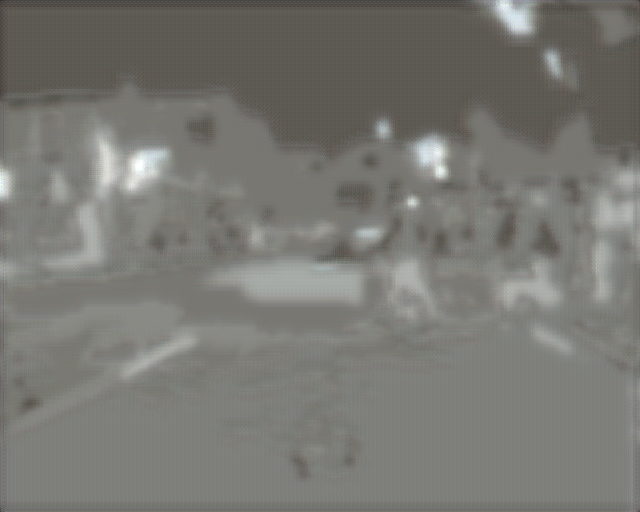

In [84]:
display(Image.fromarray(rgb_recon))

In [85]:
validation_original_rgb = img_rgb_val[0].permute(1,2,0) * 255
validation_original_rgb = validation_original_rgb.to(torch.uint8).cpu().numpy()

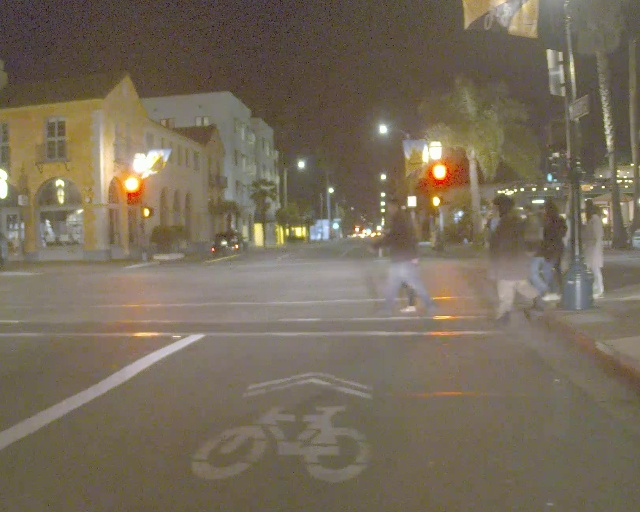

In [86]:
display(Image.fromarray(validation_original_rgb))

In [88]:
thermal_recon = recon_imgs_thermal[0] * 255
thermal_recon = thermal_recon.to(torch.uint8).permute(1,2,0).numpy()

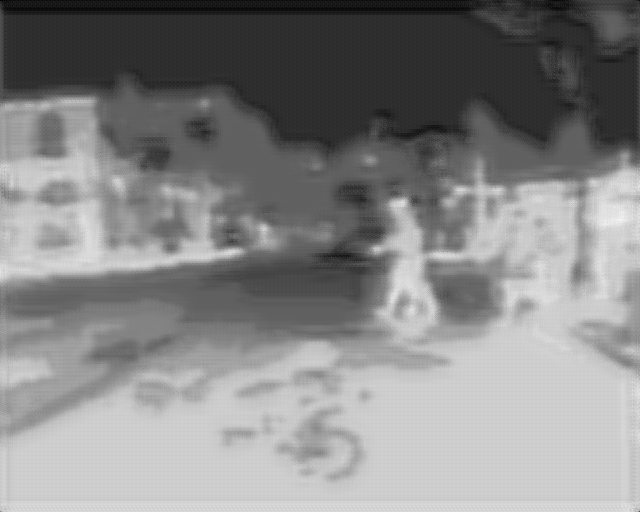

In [89]:
display(Image.fromarray(thermal_recon.squeeze(2)))

In [90]:
validation_original_thermal = img_thermal_val[0].permute(1,2,0) * 255
validation_original_thermal = validation_original_thermal.to(torch.uint8).cpu().numpy()

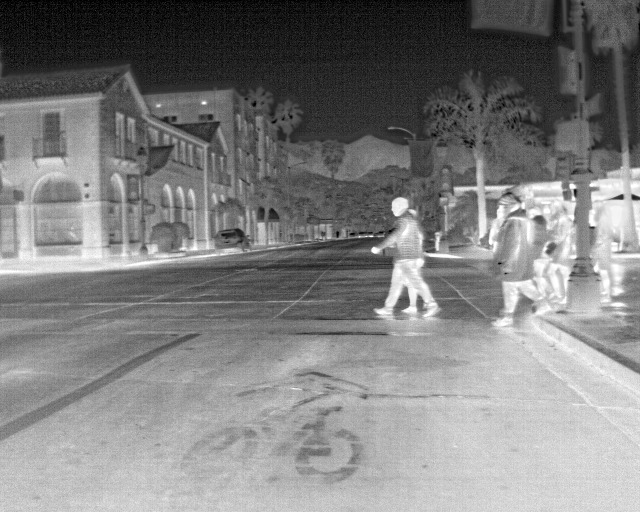

In [91]:
display(Image.fromarray(validation_original_thermal.squeeze(2)))